In [1]:
using LinearAlgebra
include("plotting.jl")
include("meshing.jl")
nothing

### Edge elements on triangles
This is based on $2 \times 2$-element resonator example from "Computational Electromagnetics", 2000
but solved with code from Davidson ("Computational Electromagnetics for RF and Microwave Engineering", 2011)

In [2]:
function SandT(x1, y1, x2, y2, x3, y3)
    global LOCALEDGENODES

    area = .5abs(det([1. x1 y1
                      1. x2 y2
                      1. x3 y3]))
    temp = inv([x1 x2 x3
                y1 y2 y3
                1. 1. 1.])
    b = temp[:,1]
    c = temp[:,2]
    a = temp[:,3]
    ∇λ = [[b[1], c[1]],
          [b[2], c[2]],
          [b[3], c[3]]]
    φ = zeros(3, 3) # φij = ∇λi ⋅ ∇λj = (bi⋅ci + bj⋅cj)
    v = zeros(3, 3) # vij = ∇λi × ∇λj = (bi⋅cj - bj⋅ci)ẑ
    for ii = 1:3
       for jj = 1:3
           φ[ii, jj] = b[ii] * b[jj] + c[ii] * c[jj]
           v[ii, jj] = b[ii] * c[jj] - b[jj] * c[ii]
       end 
    end

    M = [2. 1. 1.
         1. 2. 1.
         1. 1. 2.] / 12.0

    # Compute S and T
    S = zeros(3, 3)
    T = zeros(3, 3)
    for ii = 1:3
       for jj = 1:3
         i1 = LOCALEDGENODES[ii,1]
         i2 = LOCALEDGENODES[ii,2]
         j1 = LOCALEDGENODES[jj,1]
         j2 = LOCALEDGENODES[jj,2]
         S[ii,jj] = 4area*v[i1, i2] * v[j1, j2]
         T[ii,jj] = area*(φ[i2, j2] * M[i1, j1] +
                        - φ[i2, j1] * M[i1, j2] +
                        - φ[i1, j2] * M[i2, j1] +
                        + φ[i1, j1] * M[i2, j2])
       end 
    end
    
    return S, T
end

SandT (generic function with 1 method)

In [3]:
function simplex2D(elem_num, xp, yp)
    global ELEMENTS
    global NODE_COORD 

    trinodes = ELEMENTS[elem_num, :]; 
    x1 = NODE_COORD[trinodes[1],1];
    y1 = NODE_COORD[trinodes[1],2];
    x2 = NODE_COORD[trinodes[2],1];
    y2 = NODE_COORD[trinodes[2],2];
    x3 = NODE_COORD[trinodes[3],1];
    y3 = NODE_COORD[trinodes[3],2];

    σ0 = det([1. x1 y1; 1. x2 y2; 1. x3 y3]);
    σ1 = det([1. xp yp; 1. x2 y2; 1. x3 y3]);
    σ2 = det([1. x1 y1; 1. xp yp; 1. x3 y3]);
    σ3 = det([1. x1 y1; 1. x2 y2; 1. xp yp]);
    λ  = [σ1/σ0, σ2/σ0, σ3/σ0]
    return λ
end

simplex2D (generic function with 1 method)

In [4]:
# Parameters
ε0 = 1.
μ0 = 1.
εr = 1.
μr = 1.
σ  = 0.
ε  = ε0 * εr
μ  = μ0 * μr

# Meshing
a = 2.
b = 2.
nothing

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/bach/.julia/packages/PyPlot/XHEG0/src/init.jl:192


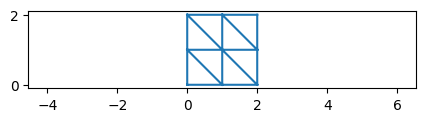

In [5]:
using PyPlot

LOCALEDGENODES = [1 2; 1 3; 2 3]
trimesh(a, b, 2, 2)
triedgemake()

figure(figsize=(5,1))
triplot(NODE_COORD[:,1], NODE_COORD[:,2], triangles=(ELEMENTS .- 1)); # subtract 1 as we go into Python-world
axis("equal");

In [6]:
DOF_NONE = 0
DOF_PEC  = 1

function dof_type(a, b)
    global NUM_EDGES
    global EDGES
    global NODE_COORD
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
       node1 = EDGES[i_edge, 1]
       node2 = EDGES[i_edge, 2]
       if NODE_COORD[node1, 2] ≈ 0. && NODE_COORD[node2, 2] ≈ 0. # ie y=0
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 2] ≈ b  && NODE_COORD[node2, 2] ≈ b  # ie y=b
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ 0. && NODE_COORD[node2, 1] ≈ 0. # ie x=0
           dof_flag[i_edge] = DOF_PEC
       end
       if NODE_COORD[node1, 1] ≈ a  && NODE_COORD[node2, 1] ≈ a  # ie x=a
           dof_flag[i_edge] = DOF_PEC
       end
    end
    return dof_flag
end

dof_type (generic function with 1 method)

In [7]:
function dof_renumber!(dof, Γ)
    global NUM_EDGES
    global NUM_DOFS
    last = 0
    for i_edge = 1:NUM_EDGES
       if Γ[i_edge] == 0
         dof[i_edge] = last + 1
         last += 1
       else
         dof[i_edge] = 0
       end
    end
    NUM_DOFS = last
    return dof
end

dof_renumber! (generic function with 1 method)

In [8]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(a, b)
dof_renumber!(dof, Γ);

In [9]:
# ASSUMPTION: Waveguide is homogenous
# Assemble stiffness and mass matrices
S = zeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
T = zeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ

for ielem = 1:NUM_ELEMS # Assemble by elements
  trinodes = ELEMENTS[ielem, :]
  Se, Te = SandT(NODE_COORD[trinodes[1],1], NODE_COORD[trinodes[1],2],
                 NODE_COORD[trinodes[2],1], NODE_COORD[trinodes[2],2],
                 NODE_COORD[trinodes[3],1], NODE_COORD[trinodes[3],2])
  
  for jedge = 1:3
    jj = dof[ELEMENT_EDGES[ielem, jedge]]
    if jj == 0 continue end
    for kedge = 1:3
      kk = dof[ELEMENT_EDGES[ielem, kedge]]
      if kk == 0 continue end
      S[jj, kk] = S[jj, kk] + (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + (μ0*ε) * Te[jedge, kedge]
    end
  end
end

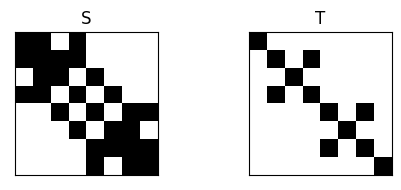

In [10]:
figure(figsize=(5, 2))
subplot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

In [11]:
using LinearAlgebra

k², e = eigen(S, T)
k²

8-element Array{Float64,1}:
 -3.761075313495586e-15
  2.20204102886729
  2.399999999999998
  5.071796769724493
 12.0
 14.399999999999999
 18.92820323027551
 21.797958971132708

In [12]:
e

8×8 Array{Float64,2}:
  3.84593e-16  -0.612372  5.72081e-15  …  -0.866025      0.612372
  0.5          -0.5       0.547723         0.5          -0.5
  0.5          -0.612372  5.8181e-15      -5.71688e-16   0.612372
  0.5           0.5       0.547723        -0.5           0.5
 -0.5           0.5       0.547723         0.5           0.5
 -0.5          -0.612372  5.31254e-15  …  -7.37062e-16   0.612372
 -0.5          -0.5       0.547723        -0.5          -0.5
  2.48656e-16  -0.612372  5.77193e-15      0.866025      0.612372

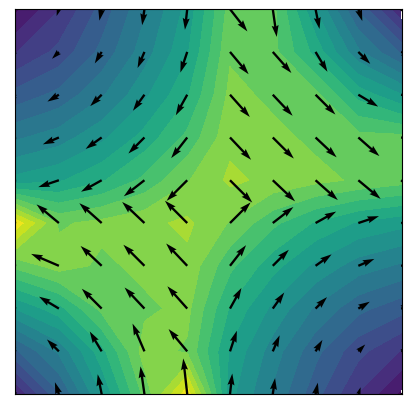

In [13]:
x = 0.1:0.2:1.9
y = 0.1:0.2:1.9
E = evaluate(WhitneyTriangleElement(), e[:, 4], dof, x, y)
normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx, yy = meshgrid(x, y);

figure(figsize=(5, 5))
contourf(xx', yy', normE, levels=20)
quiver(xx', yy', E[:, :, 1], E[:, :, 2])
xlim([-0.1, +2.1])
ylim([-0.1, +2.1]); 
axis("equal"); xticks([]); yticks([]);

### Edge elements on cartesian grids
This is based on $2 \times 2$-element resonator example from "Computational Electromagnetics", 2000

In [14]:
function dof_type(el2ed)
    global NUM_EDGES
    global EDGES
    dof_flag = zeros(Int64, NUM_EDGES)
    
    for i_edge = 1:NUM_EDGES
        if sum(el2ed .== i_edge) == 1
            dof_flag[i_edge] = 1
        end
    end
    return dof_flag
end

dof_type (generic function with 2 methods)

In [15]:
n, m = 2, 2
lx = 2. / n
ly = 2. / m
el2ed, el2edd = quadmesh(a, b, n, m);

In [16]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(el2ed)
dof_renumber!(dof, Γ);
dof = [0,0,0,1,0,3,4,0,2,0,0,0]; # override the natural order to align with Rylander's results

In [17]:
S = zeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
T = zeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2  0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:4 # Assemble by elements
  Se = stiffness_element(a/2, b/2)
  Te = mass_element(a/2, b/2)
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
    end
  end
end

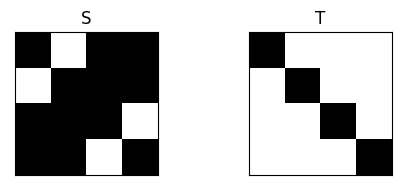

In [18]:
figure(figsize=(5, 2))
subplot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

In [19]:
using LinearAlgebra

k², e = eigen(S, T)
k²

4-element Array{Float64,1}:
 -6.539907504432563e-16
  3.0
  3.0000000000000004
  5.999999999999999

In [20]:
e

4×4 Array{Float64,2}:
 -0.612372   0.866025     -2.71948e-16  -0.612372
  0.612372   0.866025      2.71948e-16   0.612372
 -0.612372  -1.35974e-16   0.866025      0.612372
  0.612372   0.0           0.866025     -0.612372

### Better-resolved resonator
It is the example presented in **6.5.4.2 Better-Resolved Resonator** describing a $1.3\ \text{m} \times 0.9\ \text{m}$ cavity.

In [21]:
a, b = 1.3, 0.9
n, m = 13, 9
lx = a / n
ly = b / m
el2ed, el2edd = quadmesh(a, b, n, m);

In [22]:
dof = collect(1:NUM_EDGES)

Γ = dof_type(el2ed)
dof_renumber!(dof, Γ);

In [23]:
S = zeros(NUM_DOFS, NUM_DOFS) # 1/μr ∫( ∇Ni × ∇Nj )dΩ
T = zeros(NUM_DOFS, NUM_DOFS) # μ0 ε ∫( ∇Ni ⋅ ∇Nj )dΩ
stiffness_element(lx, ly) =
[lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx
 lx/ly  1  lx/ly  1
   1  ly/lx  1  ly/lx]

mass_element(lx, ly) = (lx * ly) / 6.0 *
[ 2  0 -1  0
  0  2  0 -1
 -1  0  2  0
  0 -1  0  2]

# ASSUMPTION: Waveguide is homogenous
for ielem = 1:NUM_ELEMS # Assemble by elements
  Se = stiffness_element(lx, ly)
  Te = mass_element(lx, ly)
  for jedge = 1:4
    dj = el2edd[ielem, jedge]
    jj = dof[el2ed[ielem, jedge]]
    if jj == 0
      continue
    end
    
    for kedge = 1:4
      dk = el2edd[ielem, kedge]
      kk = dof[el2ed[ielem, kedge]]
      if kk == 0
        continue
      end

      S[jj, kk] = S[jj, kk] + dj * dk * (1/μr) * Se[jedge, kedge]
      T[jj, kk] = T[jj, kk] + dj * dk * (μ0*ε) * Te[jedge, kedge]
    end
  end
end

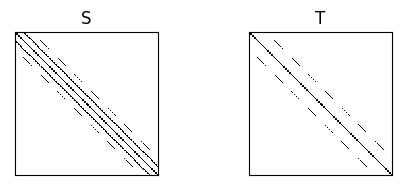

In [24]:
figure(figsize=(5, 2))
subplot(1, 2, 1); spy(S); title("S"); xticks([]); yticks([]);
subplot(1, 2, 2); spy(T); title("T"); xticks([]); yticks([]);
tight_layout()

In [25]:
using LinearAlgebra
# the first (n-1)(m-1) eigenvalues correspond to E = -∇φ
nondc = 1+(n-1)*(m-1) : NUM_DOFS
k², e = eigen(S, T)
k² = k²[nondc]

116-element Array{Float64,1}:
    5.868478959131525
   12.308915317405164
   18.177394276536873
   23.81820550965262
   36.127120827057965
   50.74876308579057
   54.90011316046203
   56.61724204492238
   67.20902847786735
   74.5669685954437
  100.91690729028096
  105.64887624625281
  113.22582260768637
    ⋮
 1515.7636015844569
 1534.7435668398628
 1591.5830957352673
 1615.0103014597876
 1697.0099487531397
 1749.172233874786
 1754.661007048519
 1873.733826762212
 1935.9073542172023
 2007.8957591772094
 2112.631232226274
 2246.7931646412717

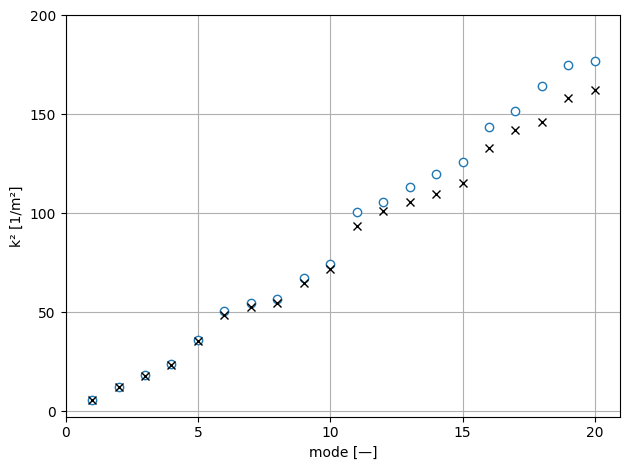

In [26]:
k²ref = sort(reshape([(π*n/1.3)^2 + (π*m/0.9)^2 for n=0:5, m=0:5 if n > 0 || m > 0], :))

plot(1:20, k²[1:20], "o", mfc="w")
plot(1:20, k²ref[1:20], "kx"); grid()
xticks(0:5:20)
yticks(0:50:200)
xlabel("mode [—]")
ylabel("k² [1/m²]")
tight_layout()

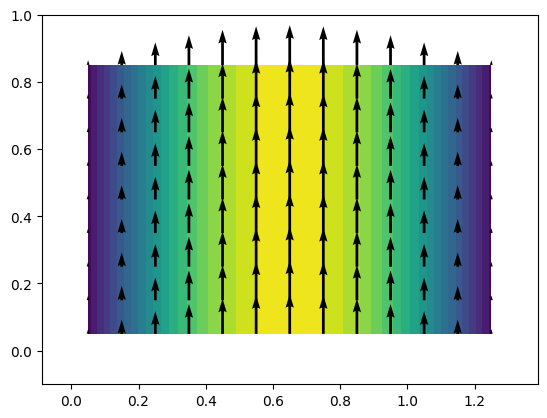

In [27]:
elem = WhitneyRectangleElement()
x = 0.05:0.1:1.25
y = 0.05:0.1:0.85
E = evaluate(elem, e[:, first(nondc)], dof, x, y, n, m, lx, ly, el2ed, el2edd)

normE  = @. sqrt(E[:, :, 1]^2 + E[:, :, 2]^2)
xx, yy = meshgrid(x, y);

contourf(xx', yy', normE, levels=20)
quiver(xx', yy', E[:, :, 1], E[:, :, 2])
axis("equal");
xlim([-0.1, +1.4])
ylim([-0.1, +1.0]); 